# Simple Moments Parameter Analysis

This notebook provides a straightforward analysis of moments optimization results, comparing ground truth parameters with estimated values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration - UPDATE THESE PATHS FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'IM_symmetric'  # Change this to your experiment
BASE_PATH = Path(f'/sietch_colab/akapoor/Infer_Demography/experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
RUNS_PATH = BASE_PATH / 'runs'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Runs path: {RUNS_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {RUNS_PATH.exists()}")

Experiment: IM_symmetric
Simulations path: /sietch_colab/akapoor/Infer_Demography/experiments/IM_symmetric/simulations
Runs path: /sietch_colab/akapoor/Infer_Demography/experiments/IM_symmetric/runs
Paths exist: True, True


In [3]:
def load_ground_truth(simulations_path):
    """Load ground truth parameters from simulation directories."""
    gt_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                gt_data[sim_id] = params
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"Loaded ground truth for {len(gt_data)} simulations")
    return gt_data

def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        meta_file = sim_dir / 'bgs.meta.json'
        
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    return coverage_data

def load_moments_results(runs_path):
    """Load moments optimization results."""
    results = {}
    
    for run_dir in sorted(runs_path.glob('run_*_*')):
        if not run_dir.is_dir():
            continue
            
        # Parse run directory name: run_sim_rep
        parts = run_dir.name.split('_')
        if len(parts) < 3:
            continue
            
        sim_id = parts[1]
        rep_id = parts[2]
        
        moments_dir = run_dir / 'inferences' / 'moments'
        if not moments_dir.exists():
            continue
            
        # Look for results file
        result_files = [
            moments_dir / 'best_fit.pkl',
            moments_dir / 'results.pkl',
            moments_dir / 'optimization_results.pkl'
        ]
        
        for result_file in result_files:
            if result_file.exists():
                try:
                    with open(result_file, 'rb') as f:
                        data = pickle.load(f)
                    
                    if sim_id not in results:
                        results[sim_id] = {}
                    results[sim_id][rep_id] = data
                    break  # Use first found file
                except Exception as e:
                    print(f"Error loading {result_file}: {e}")
    
    print(f"Loaded moments results for {len(results)} simulations")
    return results

def extract_parameters(moments_data):
    """Extract parameters and likelihood from moments results."""
    params = {}
    likelihood = None
    
    # Handle different result file formats
    if isinstance(moments_data, dict):
        # Look for parameters
        if 'best_params' in moments_data:
            if isinstance(moments_data['best_params'], dict):
                params = moments_data['best_params']
            elif 'param_order' in moments_data:
                order = moments_data['param_order']
                values = moments_data['best_params']
                params = dict(zip(order, values))
        
        # Look for likelihood
        for key in ['best_ll', 'log_likelihood', 'll']:
            if key in moments_data:
                val = moments_data[key]
                likelihood = val[0] if isinstance(val, (list, tuple)) else val
                break
    
    if likelihood is not None:
        params['log_likelihood'] = float(likelihood)
    
    return params

print("Helper functions defined!")

Helper functions defined!


In [4]:
# Load the data
print("Loading ground truth parameters...")
ground_truth = load_ground_truth(SIMULATIONS_PATH)

print("\nLoading coverage data...")
coverage_data = load_coverage_data(SIMULATIONS_PATH)

print("\nLoading moments results...")
moments_results = load_moments_results(RUNS_PATH)

# Show example data
if ground_truth:
    first_sim = list(ground_truth.keys())[0]
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for key, value in ground_truth[first_sim].items():
        print(f"  {key}: {value}")

if coverage_data:
    print(f"\nExample coverage data:")
    for i, (sim_id, coverage) in enumerate(list(coverage_data.items())[:5]):
        print(f"  Sim {sim_id}: {coverage}% coverage" if coverage else f"  Sim {sim_id}: No coverage data")

if moments_results:
    first_sim = list(moments_results.keys())[0]
    first_rep = list(moments_results[first_sim].keys())[0]
    example_params = extract_parameters(moments_results[first_sim][first_rep])
    print(f"\nExample estimated parameters (sim {first_sim}, rep {first_rep}):")
    for key, value in example_params.items():
        print(f"  {key}: {value}")

Loading ground truth parameters...
Loaded ground truth for 50 simulations

Loading coverage data...
Loaded coverage data for 50 simulations
  50 simulations have coverage data

Loading moments results...
Loaded moments results for 50 simulations

Example ground truth parameters (sim 0):
  N_anc: 23241.285851823304
  N_YRI: 13222.465348586364
  N_CEU: 25772.077805350335
  m: 6.97398292256458e-05
  T_split: 2336.4582838091656

Example coverage data:
  Sim 0: 29.29304819746592% coverage
  Sim 1: 7.516451675905109% coverage
  Sim 10: 29.081814537100062% coverage
  Sim 11: 20.326662563202834% coverage
  Sim 12: 14.20339484438554% coverage

Example estimated parameters (sim 0, rep 0):
  N_anc: 14962.189530668964
  N_YRI: 6573.976913147742
  N_CEU: 29935.944213127575
  m: 2.881407073611846e-06
  T_split: 731.1388000276165
  log_likelihood: 186548.0058367088


In [5]:
# Create comparison dataframe
comparison_data = []

for sim_id in ground_truth.keys():
    if sim_id not in moments_results:
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)  # Get coverage for this simulation
    
    for rep_id, rep_data in moments_results[sim_id].items():
        est_params = extract_parameters(rep_data)
        
        # Find common parameters
        common_params = set(gt_params.keys()) & set(est_params.keys())
        common_params.discard('log_likelihood')  # Don't compare likelihood
        
        for param in common_params:
            gt_val = gt_params[param]
            est_val = est_params[param]
            
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': param,
                'ground_truth': gt_val,
                'estimated': est_val,
                'absolute_error': est_val - gt_val,
                'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
                'coverage_percent': coverage
            })
        
        # Add likelihood separately
        if 'log_likelihood' in est_params:
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': 'log_likelihood',
                'ground_truth': np.nan,
                'estimated': est_params['log_likelihood'],
                'absolute_error': np.nan,
                'relative_error': np.nan,
                'coverage_percent': coverage
            })

df = pd.DataFrame(comparison_data)
print(f"Created comparison dataframe with {len(df)} rows")
print(f"Parameters: {sorted(df['parameter'].unique())}")
print(f"Simulations: {len(df['simulation'].unique())}")

# Check coverage data distribution
coverage_stats = df['coverage_percent'].describe()
print(f"\nCoverage percentage statistics:")
print(coverage_stats)

# Show first few rows
display(df.head(10))

Created comparison dataframe with 300 rows
Parameters: ['N_CEU', 'N_YRI', 'N_anc', 'T_split', 'log_likelihood', 'm']
Simulations: 50

Coverage percentage statistics:
count    300.000000
mean      15.284506
std        9.088694
min        1.393990
25%        6.468571
50%       14.938405
75%       23.999596
max       29.920788
Name: coverage_percent, dtype: float64


,simulation,replicate,parameter,ground_truth,estimated,absolute_error,relative_error,coverage_percent
0,0,0,N_YRI,13222.465349,6573.976913,-6648.488435,-0.502818,29.293048
1,0,0,N_anc,23241.285852,14962.189531,-8279.096321,-0.356224,29.293048
2,0,0,T_split,2336.458284,731.138800,-1605.319484,-0.687074,29.293048
3,0,0,N_CEU,25772.077805,29935.944213,4163.866408,0.161565,29.293048
4,0,0,m,0.000070,0.000003,-0.000067,-0.958683,29.293048
5,0,0,log_likelihood,NaN,186548.005837,NaN,NaN,29.293048
6,1,0,N_YRI,1408.882177,1834.375207,425.493030,0.302008,7.516452
7,1,0,N_anc,19603.747955,2979.946149,-16623.801805,-0.847991,7.516452
8,1,0,T_split,11949.289428,500.000000,-11449.289428,-0.958157,7.516452
9,1,0,N_CEU,698.884648,275.493239,-423.391409,-0.605810,7.516452


Plotting 5 parameters: ['N_YRI', 'N_anc', 'T_split', 'N_CEU', 'm']


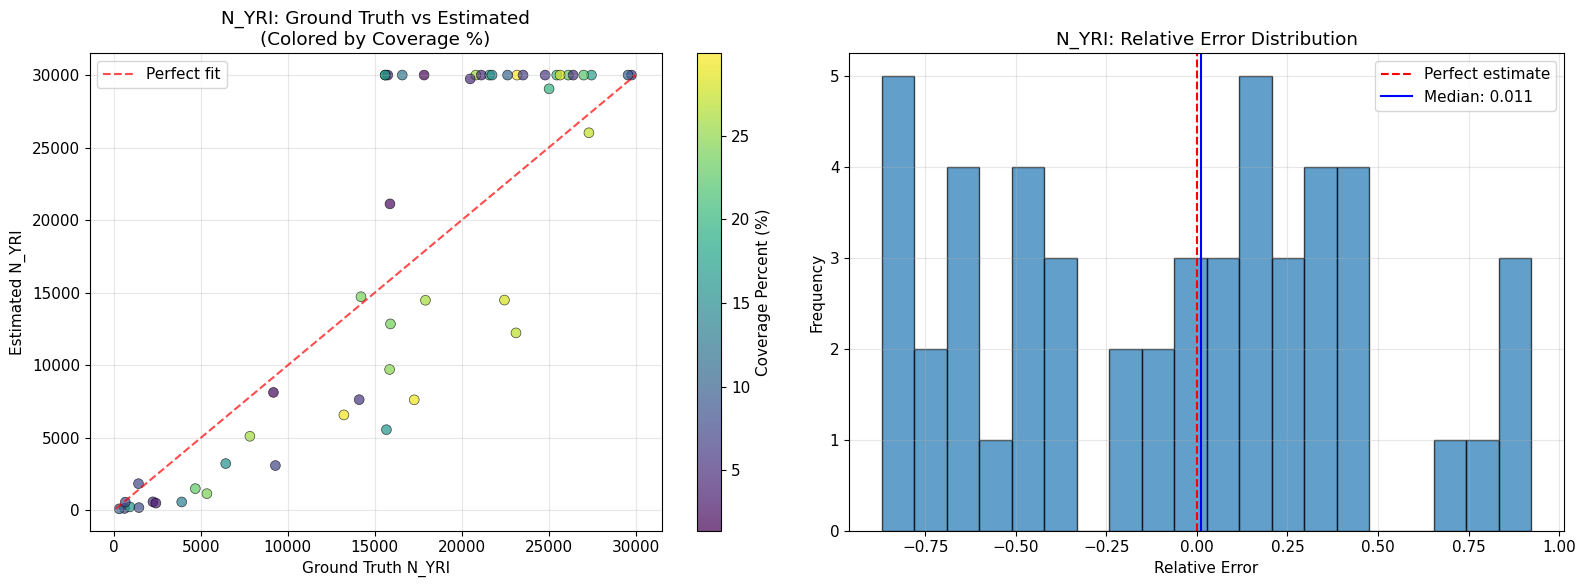


N_YRI Statistics:
  Estimates: 50
  Correlation: 0.8697
  RMSE: 6721.9507
  Mean relative error: -0.0678
  Std relative error: 0.5137
  Coverage range: 1.4% - 29.9%
  Mean coverage: 15.3%




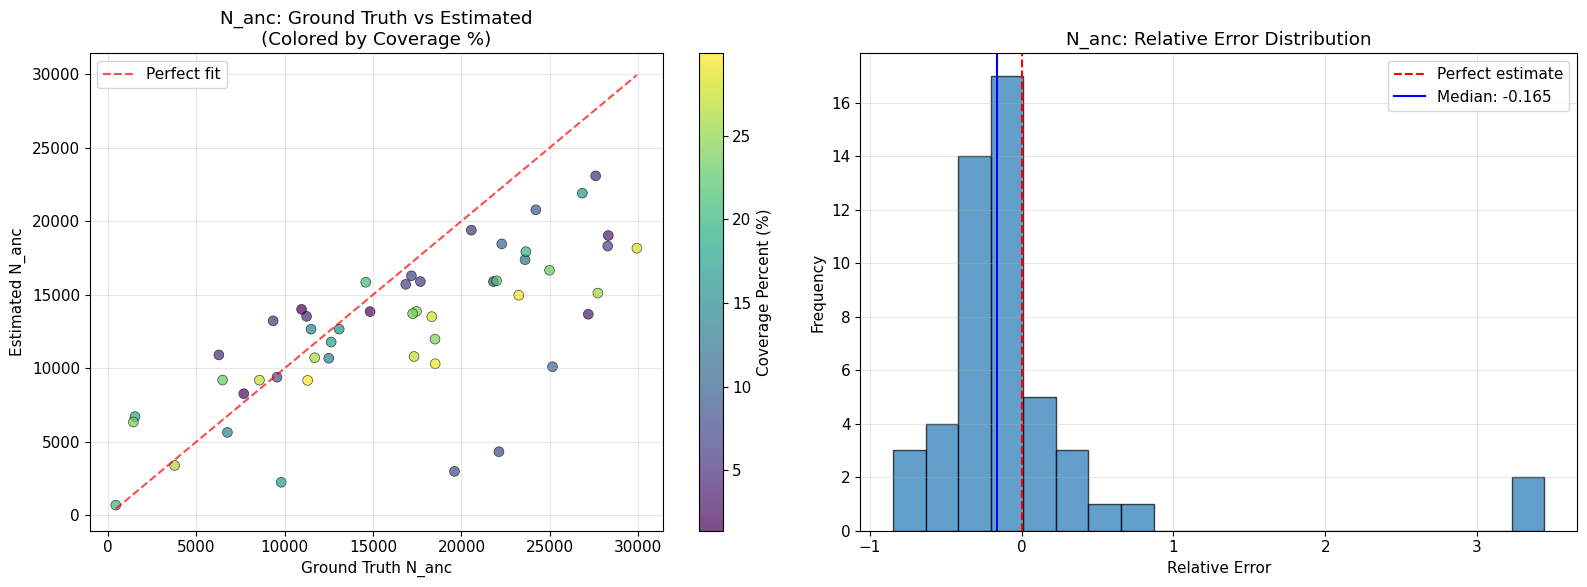


N_anc Statistics:
  Estimates: 50
  Correlation: 0.7148
  RMSE: 6676.6972
  Mean relative error: -0.0122
  Std relative error: 0.7756
  Coverage range: 1.4% - 29.9%
  Mean coverage: 15.3%




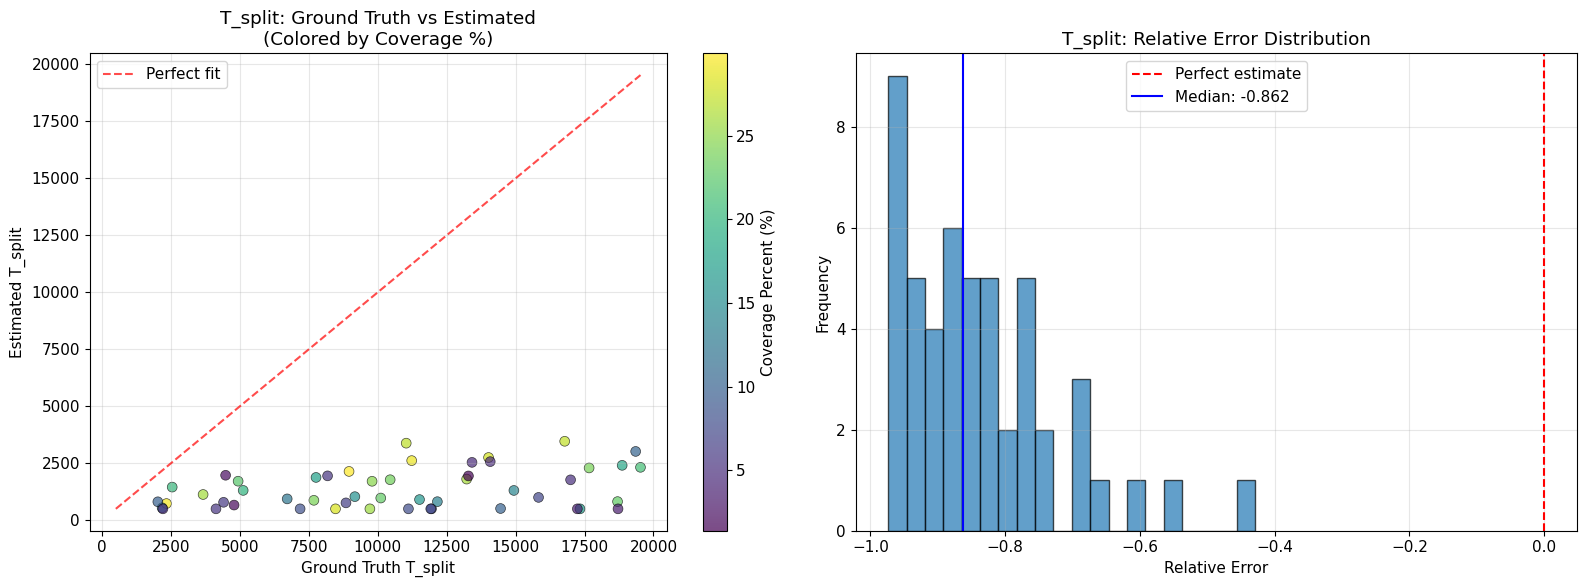


T_split Statistics:
  Estimates: 50
  Correlation: 0.3453
  RMSE: 10506.2655
  Mean relative error: -0.8367
  Std relative error: 0.1164
  Coverage range: 1.4% - 29.9%
  Mean coverage: 15.3%




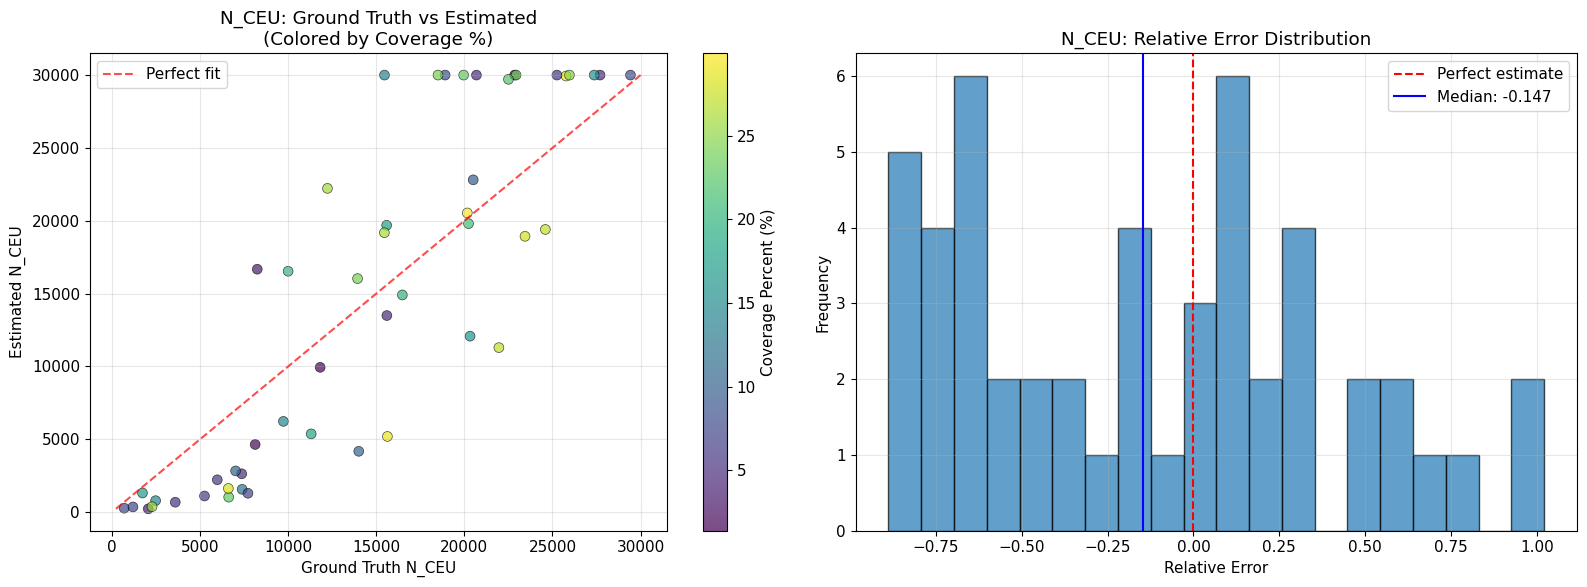


N_CEU Statistics:
  Estimates: 50
  Correlation: 0.8685
  RMSE: 6092.5459
  Mean relative error: -0.1398
  Std relative error: 0.5295
  Coverage range: 1.4% - 29.9%
  Mean coverage: 15.3%




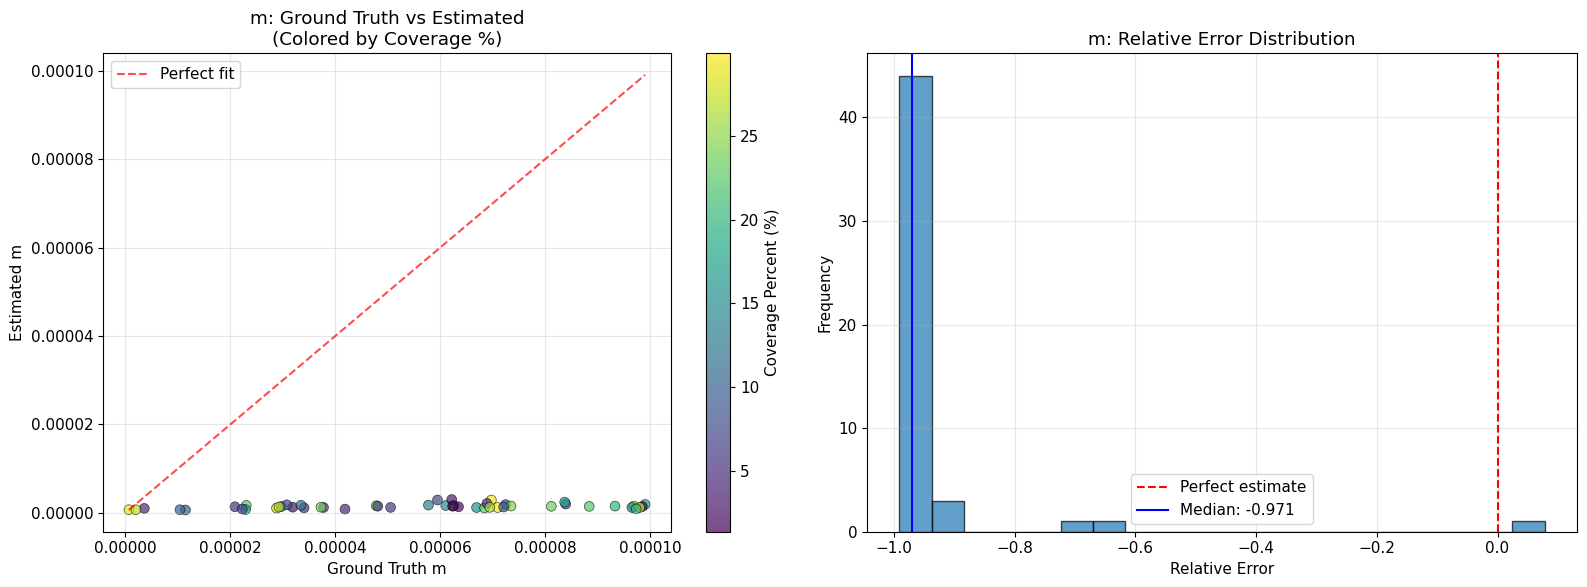


m Statistics:
  Estimates: 50
  Correlation: 0.4057
  RMSE: 0.0001
  Mean relative error: -0.9368
  Std relative error: 0.1575
  Coverage range: 1.4% - 29.9%
  Mean coverage: 15.3%


Cross-Parameter Analysis:
Not enough migration parameters found for cross-parameter analysis


In [6]:
# Plot parameter comparisons
def plot_parameter(df, param_name):
    """Plot ground truth vs estimated for a parameter, colored by coverage percentage."""
    param_data = df[df['parameter'] == param_name]
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot colored by coverage
    coverage = param_data['coverage_percent']
    
    # Handle case where some coverage data might be missing
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = ax1.scatter(param_data[valid_coverage]['ground_truth'], 
                            param_data[valid_coverage]['estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(param_data):
            ax1.scatter(param_data[~valid_coverage]['ground_truth'], 
                       param_data[~valid_coverage]['estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        ax1.scatter(param_data['ground_truth'], param_data['estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {param_name}')
    ax1.set_ylabel(f'Estimated {param_name}')
    ax1.set_title(f'{param_name}: Ground Truth vs Estimated\n(Colored by Coverage %)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{param_name}: Relative Error Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated'])
    if len(valid_data) > 0:
        corr = valid_data['ground_truth'].corr(valid_data['estimated'])
        rmse = np.sqrt((valid_data['absolute_error']**2).mean())
        print(f"\n{param_name} Statistics:")
        print(f"  Estimates: {len(valid_data)}")
        print(f"  Correlation: {corr:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Coverage-related statistics
        coverage_valid = valid_data['coverage_percent'].notna()
        if coverage_valid.sum() > 0:
            print(f"  Coverage range: {valid_data['coverage_percent'].min():.1f}% - {valid_data['coverage_percent'].max():.1f}%")
            print(f"  Mean coverage: {valid_data['coverage_percent'].mean():.1f}%")

def plot_cross_parameter(df, param1_est, param2_gt, title_suffix=""):
    """Plot estimated param1 vs ground truth param2 to check for parameter confusion, colored by coverage."""
    # Get data for both parameters
    param1_data = df[df['parameter'] == param1_est][['simulation', 'replicate', 'estimated', 'coverage_percent']].rename(columns={'estimated': f'{param1_est}_estimated'})
    param2_data = df[df['parameter'] == param2_gt][['simulation', 'replicate', 'ground_truth']].rename(columns={'ground_truth': f'{param2_gt}_ground_truth'})
    
    # Merge data
    merged_data = pd.merge(param1_data, param2_data, on=['simulation', 'replicate'], how='inner')
    
    if len(merged_data) == 0:
        print(f"No overlapping data for {param1_est} estimated vs {param2_gt} ground truth")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Scatter plot colored by coverage
    coverage = merged_data['coverage_percent']
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = plt.scatter(merged_data[valid_coverage][f'{param2_gt}_ground_truth'], 
                            merged_data[valid_coverage][f'{param1_est}_estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(merged_data):
            plt.scatter(merged_data[~valid_coverage][f'{param2_gt}_ground_truth'], 
                       merged_data[~valid_coverage][f'{param1_est}_estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        plt.scatter(merged_data[f'{param2_gt}_ground_truth'], merged_data[f'{param1_est}_estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'Ground Truth {param2_gt}')
    plt.ylabel(f'Estimated {param1_est}')
    plt.title(f'Cross-Parameter Analysis: {param1_est} Estimated vs {param2_gt} Ground Truth{title_suffix}\n(Colored by Coverage %)')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = merged_data[f'{param2_gt}_ground_truth'].corr(merged_data[f'{param1_est}_estimated'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cross-parameter correlation ({param1_est} est vs {param2_gt} gt): {corr:.4f}")
    print(f"Data points: {len(merged_data)}")
    
    return corr

# Plot each parameter
parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
print(f"Plotting {len(parameters)} parameters: {parameters}")

for param in parameters:
    plot_parameter(df, param)
    print("\n" + "="*60 + "\n")

# Cross-parameter analysis
print("Cross-Parameter Analysis:")
print("="*50)

# Check for parameter confusion between migration rates
available_params = df['parameter'].unique()
migration_params = [p for p in available_params if 'm' in p.lower() and p != 'log_likelihood']

if len(migration_params) >= 2:
    print(f"Found migration parameters: {migration_params}")
    
    # Plot m12 estimated vs m21 ground truth (and vice versa)
    for i, param1 in enumerate(migration_params):
        for j, param2 in enumerate(migration_params):
            if i != j:  # Don't compare parameter with itself
                print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
                corr = plot_cross_parameter(df, param1, param2)
                print("-" * 40)
else:
    print("Not enough migration parameters found for cross-parameter analysis")
    
# You can also check other parameter pairs
other_cross_checks = [
    # Add any other parameter pairs you want to check, e.g.:
    # ('N_YRI', 'N_CEU'),
    # ('T_split', 'N_anc'),
]

for param1, param2 in other_cross_checks:
    if param1 in available_params and param2 in available_params:
        print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
        plot_cross_parameter(df, param1, param2)
        print("-" * 40)

Best Estimates Summary (Highest Likelihood per Simulation):

N_YRI:
  Count: 50
  Mean relative error: -0.0678
  Std relative error: 0.5137
  Within 5%: 4/50 (8.0%)
  Within 10%: 5/50 (10.0%)

N_anc:
  Count: 50
  Mean relative error: -0.0122
  Std relative error: 0.7756
  Within 5%: 2/50 (4.0%)
  Within 10%: 11/50 (22.0%)

T_split:
  Count: 50
  Mean relative error: -0.8367
  Std relative error: 0.1164
  Within 5%: 0/50 (0.0%)
  Within 10%: 0/50 (0.0%)

N_CEU:
  Count: 50
  Mean relative error: -0.1398
  Std relative error: 0.5295
  Within 5%: 3/50 (6.0%)
  Within 10%: 6/50 (12.0%)

m:
  Count: 50
  Mean relative error: -0.9368
  Std relative error: 0.1575
  Within 5%: 0/50 (0.0%)
  Within 10%: 1/50 (2.0%)


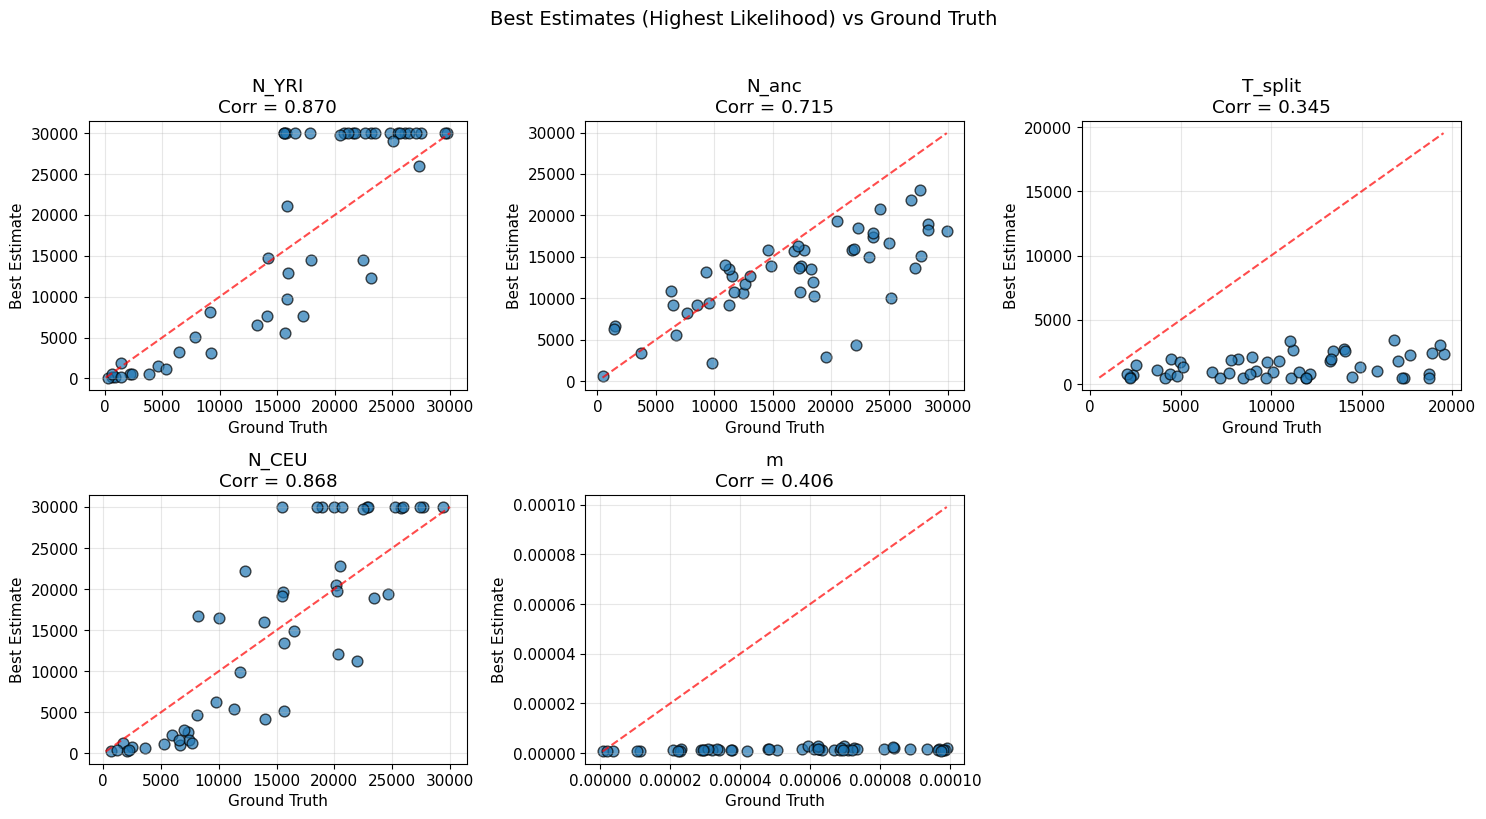

In [7]:
# Best estimates analysis (highest likelihood per simulation)
ll_data = df[df['parameter'] == 'log_likelihood']

if not ll_data.empty:
    best_estimates = []
    
    for sim_id in ll_data['simulation'].unique():
        sim_ll = ll_data[ll_data['simulation'] == sim_id]
        best_rep = sim_ll.loc[sim_ll['estimated'].idxmax(), 'replicate']
        
        # Get all parameters for this simulation's best replicate
        best_data = df[(df['simulation'] == sim_id) & 
                      (df['replicate'] == best_rep) & 
                      (df['parameter'] != 'log_likelihood')]
        
        for _, row in best_data.iterrows():
            best_estimates.append({
                'simulation': row['simulation'],
                'parameter': row['parameter'],
                'ground_truth': row['ground_truth'],
                'best_estimate': row['estimated'],
                'relative_error': row['relative_error']
            })
    
    best_df = pd.DataFrame(best_estimates)
    
    if not best_df.empty:
        print("Best Estimates Summary (Highest Likelihood per Simulation):")
        print("=" * 60)
        
        for param in best_df['parameter'].unique():
            param_data = best_df[best_df['parameter'] == param]
            
            print(f"\n{param}:")
            print(f"  Count: {len(param_data)}")
            print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
            print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
            
            # Accuracy within thresholds
            within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
            within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
            total = len(param_data)
            print(f"  Within 5%: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
            print(f"  Within 10%: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
        
        # Plot best estimates
        params = best_df['parameter'].unique()
        n_params = len(params)
        
        if n_params > 0:
            cols = min(3, n_params)
            rows = (n_params + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            if n_params == 1:
                axes = [axes]
            elif rows == 1:
                axes = [axes] if cols == 1 else axes
            else:
                axes = axes.flatten()
            
            for i, param in enumerate(params):
                ax = axes[i]
                param_data = best_df[best_df['parameter'] == param]
                
                ax.scatter(param_data['ground_truth'], param_data['best_estimate'], 
                          alpha=0.7, s=60, edgecolors='black')
                
                # Identity line
                min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
                max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
                
                # Correlation
                corr = param_data['ground_truth'].corr(param_data['best_estimate'])
                ax.set_title(f'{param}\nCorr = {corr:.3f}')
                ax.set_xlabel('Ground Truth')
                ax.set_ylabel('Best Estimate')
                ax.grid(True, alpha=0.3)
            
            # Hide unused subplots
            for i in range(n_params, len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle('Best Estimates (Highest Likelihood) vs Ground Truth', 
                        fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()
    
else:
    print("No likelihood data found - cannot identify best estimates")

In [8]:
# Summary statistics by parameter
print("Overall Parameter Statistics:")
print("=" * 50)

for param in [p for p in df['parameter'].unique() if p != 'log_likelihood']:
    param_data = df[df['parameter'] == param]
    
    print(f"\n{param}:")
    print(f"  Total estimates: {len(param_data)}")
    print(f"  Simulations: {len(param_data['simulation'].unique())}")
    
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        print(f"  Mean relative error: {valid_errors.mean():.4f}")
        print(f"  Median relative error: {valid_errors.median():.4f}")
        print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Percentiles
        p25, p75 = np.percentile(np.abs(valid_errors), [25, 75])
        print(f"  25th percentile |error|: {p25:.4f}")
        print(f"  75th percentile |error|: {p75:.4f}")

print("\n" + "="*50)
print("Analysis complete!")

Overall Parameter Statistics:

N_YRI:
  Total estimates: 50
  Simulations: 50
  Mean relative error: -0.0678
  Median relative error: 0.0112
  Std relative error: 0.5137
  25th percentile |error|: 0.1815
  75th percentile |error|: 0.6776

N_anc:
  Total estimates: 50
  Simulations: 50
  Mean relative error: -0.0122
  Median relative error: -0.1649
  Std relative error: 0.7756
  25th percentile |error|: 0.1013
  75th percentile |error|: 0.4097

T_split:
  Total estimates: 50
  Simulations: 50
  Mean relative error: -0.8367
  Median relative error: -0.8623
  Std relative error: 0.1164
  25th percentile |error|: 0.7687
  75th percentile |error|: 0.9281

N_CEU:
  Total estimates: 50
  Simulations: 50
  Mean relative error: -0.1398
  Median relative error: -0.1469
  Std relative error: 0.5295
  25th percentile |error|: 0.1891
  75th percentile |error|: 0.6928

m:
  Total estimates: 50
  Simulations: 50
  Mean relative error: -0.9368
  Median relative error: -0.9706
  Std relative error: 0.1

EUR_bottleneck vs EUR_recover Cross-Parameter Analysis
Available parameters: ['N0', 'T_AFR_expansion', 'T_AFR_EUR_split', 'EUR_bottleneck', 'T_EUR_expansion', 'EUR_recover', 'AFR', 'log_likelihood']
Has EUR_bottleneck: True
Has EUR_recover: True

1. EUR_bottleneck estimated vs EUR_recover ground truth


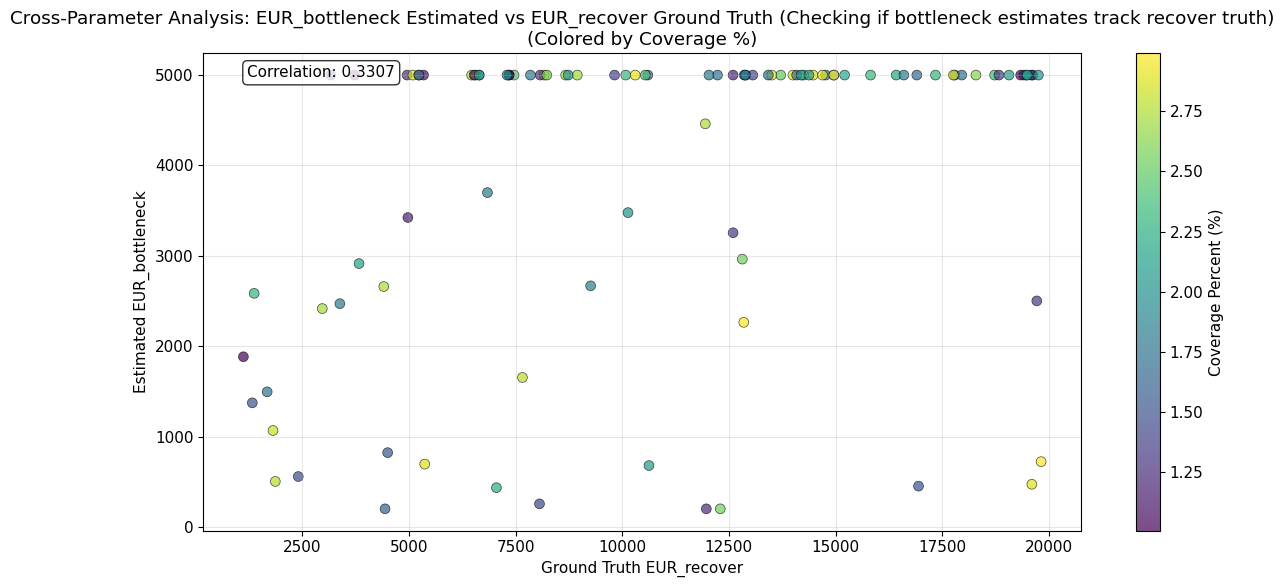

Cross-parameter correlation (EUR_bottleneck est vs EUR_recover gt): 0.3307
Data points: 100

2. EUR_recover estimated vs EUR_bottleneck ground truth


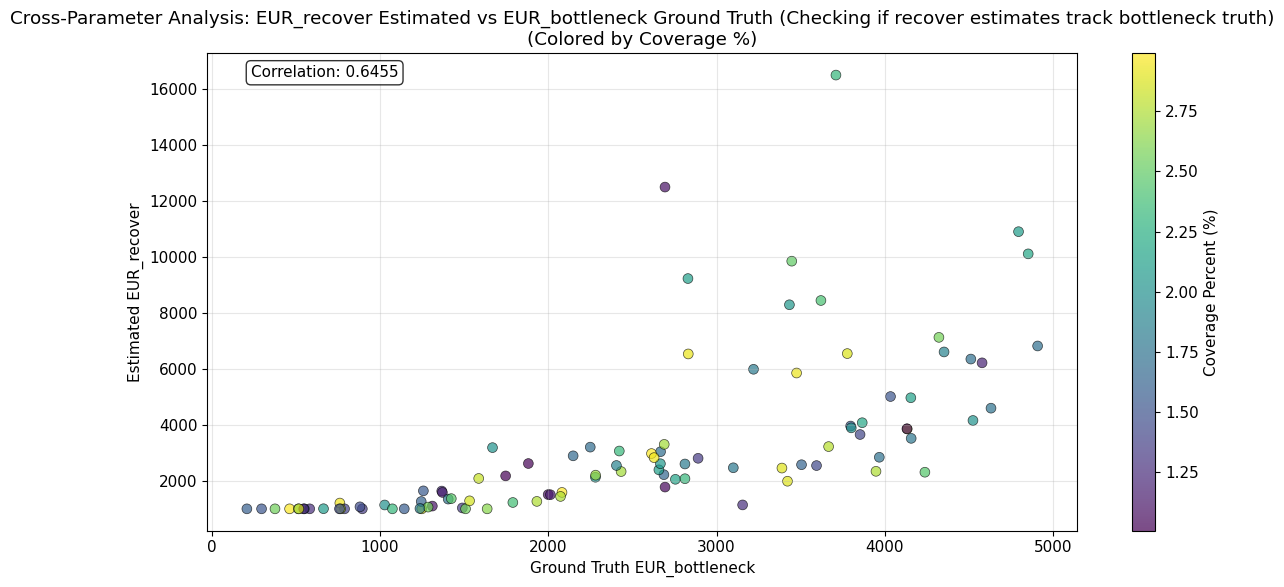

Cross-parameter correlation (EUR_recover est vs EUR_bottleneck gt): 0.6455
Data points: 100

Cross-Parameter Correlation Summary:
EUR_bottleneck est vs EUR_recover truth: 0.3307
EUR_recover est vs EUR_bottleneck truth: 0.6455

⚠️  HIGH CORRELATION DETECTED!
   This suggests potential parameter confusion between EUR_bottleneck and EUR_recover.
   The model may be having difficulty distinguishing these parameters.


In [50]:
# EUR_bottleneck vs EUR_recover cross-parameter analysis
print("EUR_bottleneck vs EUR_recover Cross-Parameter Analysis")
print("="*60)

# Check if both parameters exist in the data
available_params = df['parameter'].unique()
has_bottleneck = 'EUR_bottleneck' in available_params
has_recover = 'EUR_recover' in available_params

print(f"Available parameters: {list(available_params)}")
print(f"Has EUR_bottleneck: {has_bottleneck}")
print(f"Has EUR_recover: {has_recover}")

if has_bottleneck and has_recover:
    # Plot 1: EUR_bottleneck estimated vs EUR_recover ground truth
    print("\n1. EUR_bottleneck estimated vs EUR_recover ground truth")
    corr1 = plot_cross_parameter(df, 'EUR_bottleneck', 'EUR_recover', 
                                " (Checking if bottleneck estimates track recover truth)")
    
    # Plot 2: EUR_recover estimated vs EUR_bottleneck ground truth  
    print("\n2. EUR_recover estimated vs EUR_bottleneck ground truth")
    corr2 = plot_cross_parameter(df, 'EUR_recover', 'EUR_bottleneck',
                                " (Checking if recover estimates track bottleneck truth)")
    
    # Summary
    print(f"\nCross-Parameter Correlation Summary:")
    print(f"EUR_bottleneck est vs EUR_recover truth: {corr1:.4f}")
    print(f"EUR_recover est vs EUR_bottleneck truth: {corr2:.4f}")
    
    # Interpretation
    if abs(corr1) > 0.5 or abs(corr2) > 0.5:
        print(f"\n⚠️  HIGH CORRELATION DETECTED!")
        print(f"   This suggests potential parameter confusion between EUR_bottleneck and EUR_recover.")
        print(f"   The model may be having difficulty distinguishing these parameters.")
    else:
        print(f"\n✅ Low cross-parameter correlation - parameters appear distinguishable.")
        
elif not has_bottleneck:
    print("\n❌ EUR_bottleneck parameter not found in data")
elif not has_recover:
    print("\n❌ EUR_recover parameter not found in data")
else:
    print("\n❌ Neither EUR_bottleneck nor EUR_recover found in data")